<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/05-Time_Series/B-ERCOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing electricity usage from Electric Reliability Council of Texas (ERCOT)

We will be analyzing the electricity usage data from ERCOT.

ERCOT releases the [electricity usage of their grid](http://www.ercot.com/gridinfo/load) and they [provide archival copies of their data](http://www.ercot.com/gridinfo/load/load_hist).
(ERCOT also publishes their own load forecasts, this is a good baseline for any model.)

In [1]:
#@title Setup

!pip install -U -q statsmodels PyMySQL sqlalchemy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from sqlalchemy import create_engine
from sqlalchemy import text

In [2]:
#@title Plotting Setup

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 8x3 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 2  # Default marker size of 2 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 points

# Load and plot the data


In [3]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2015',
    db = 'ercot',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

# This query loads the dataset from the DB into the dataframe
with engine.connect() as con:
  sql = "SELECT * FROM ercot.electricity"
  df = pd.read_sql(text(sql), con=con)
  df = df.set_index('DATE_TIME')

In [4]:
df

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
DATE_TIME,,,,,,,,,
2002-01-01 01:00:00,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911
2002-01-01 02:00:00,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703
2002-01-01 03:00:00,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525
2002-01-01 04:00:00,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450
2002-01-01 05:00:00,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478
...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,13926.775034,1566.583851,4192.977787,916.124441,11942.416165,3910.031058,7401.098687,1133.093917,44989.100940
2021-12-31 21:00:00,13498.908542,1549.687559,4149.062209,886.943872,11406.911057,3681.222926,7088.478765,1102.727285,43363.942215
2021-12-31 22:00:00,13116.012129,1515.852644,4148.330779,859.408149,10978.547227,3515.077507,6800.707246,1071.686005,42005.621687


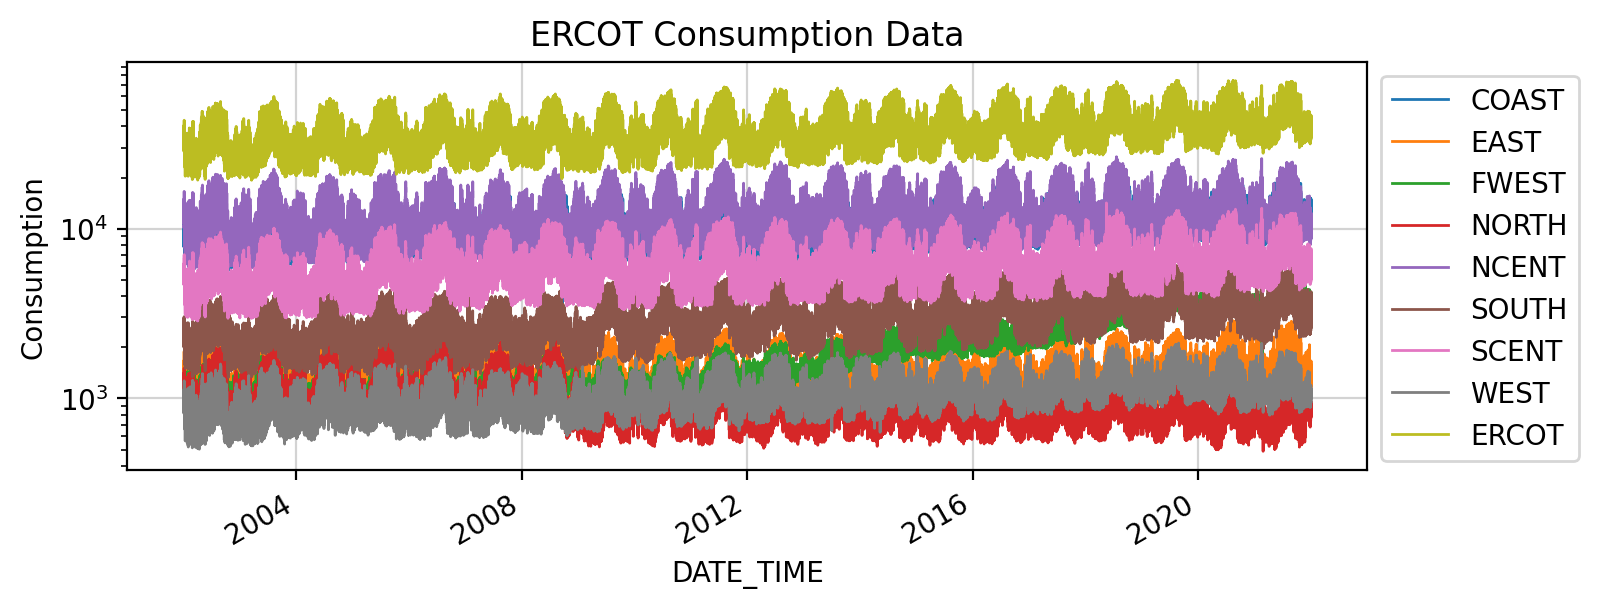

In [5]:
df.plot(
    logy=True,
    title='ERCOT Consumption Data',
    ylabel="Consumption"
)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # move the legend out of the chart

<Axes: title={'center': 'ERCOT Consumption Data'}, xlabel='DATE_TIME', ylabel='Consumption'>

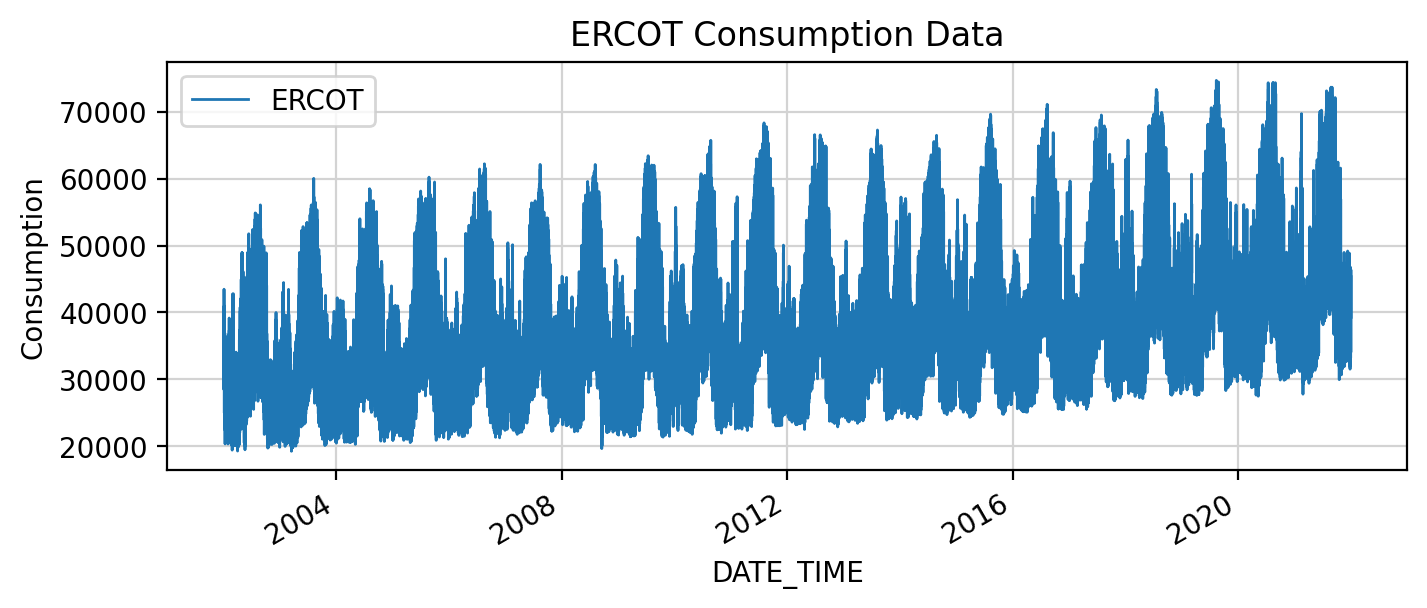

In [6]:
df.plot(
    y = 'ERCOT',
    title='ERCOT Consumption Data',
    ylabel="Consumption"
)

# Potential questions:

* We are trying to perform capacity planning. How will demand evolve over time? Can we make projections for the next 5 years?
* We care about the maximum capacity of our system as we need to avoid blackouts. Make projections for the total capacity necessary to avoid blackouts. Ideally, provide confidence intervals showing how much maximum capacity we need.
* Perform the analysis on a regional basis, and identify capacity planning for the regions (COAST, WEST, etc)

## Extracting Time Series Components: Trend, Seasonal, Residual

In [7]:
df['ERCOT'].autocorr()

0.9836856155030475

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

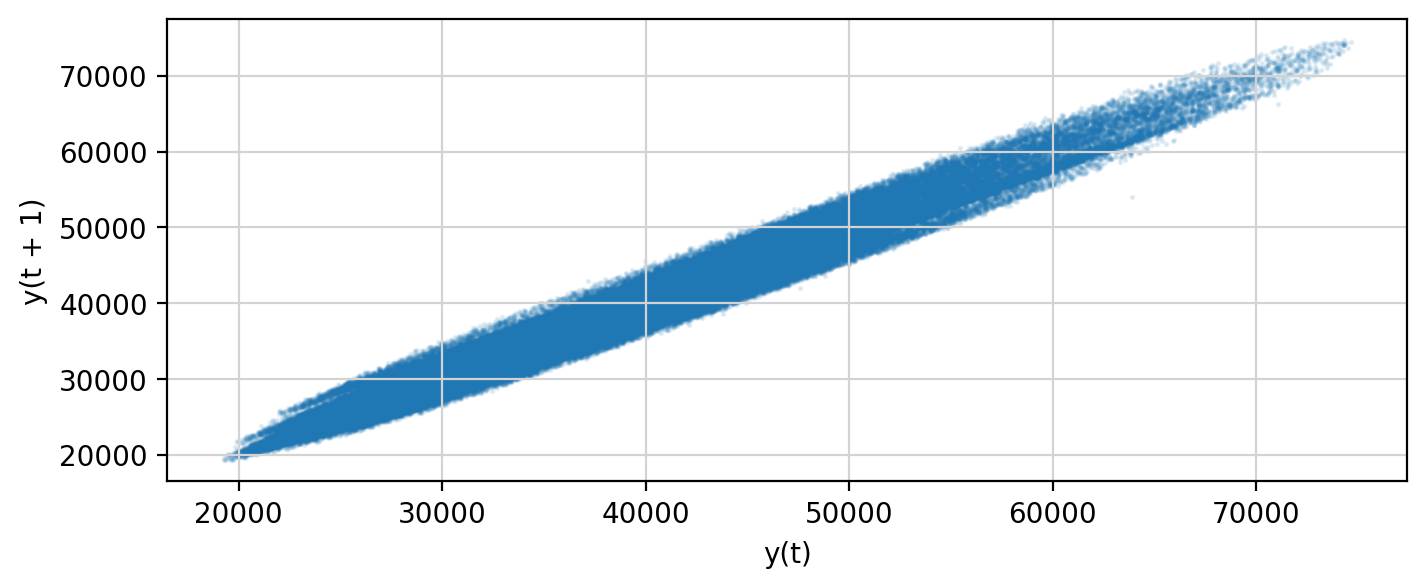

In [8]:
pd.plotting.lag_plot(df.ERCOT, lag=1, s=1, alpha=0.1 )

### Extracting Daily Seasonal Component

In [9]:
Y = df.ERCOT

decompose = seasonal_decompose(Y,
                                model='multiplicative',
                                period=24,
                                extrapolate_trend=24)

T_d, S_d, R_d = decompose.trend, decompose.seasonal, decompose.resid

<Axes: xlabel='DATE_TIME'>

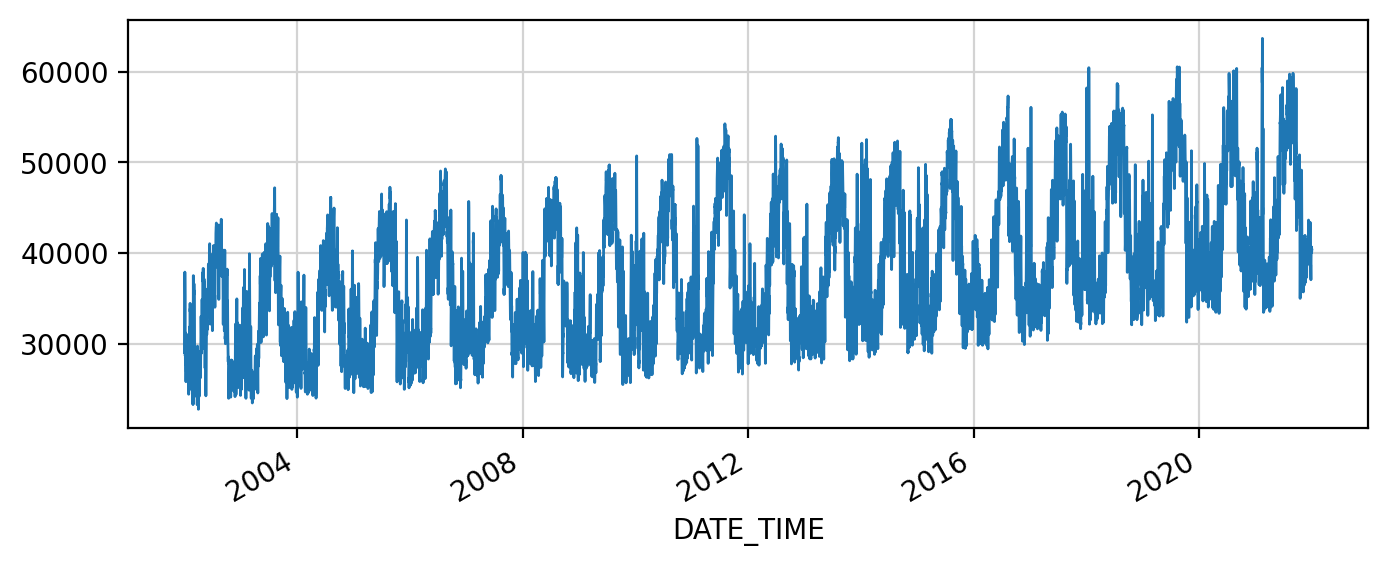

In [10]:
# plot the trend, after we remove daily seasonality
T_d.plot()

<Axes: xlabel='DATE_TIME'>

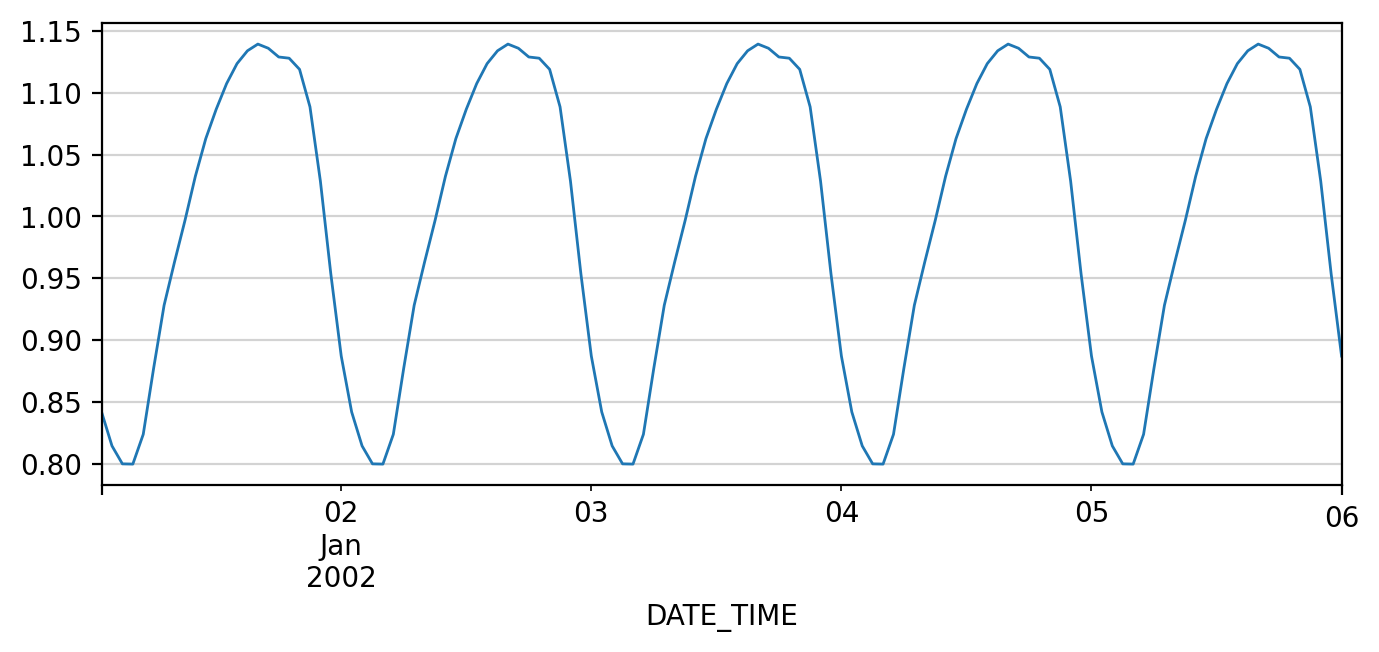

In [11]:
(
    S_d # the daily seasonal trend
    .head(24 * 5) # plot the first five days
    .plot()
)

We also plot the residuals to see the quality of the removal of the seasonal component. Honestly, not a great outcome: our techniques are pretty naive, and do not account for the fluctuating magnitude of the changes (aka "_clustered volatility_"). Dealing with clustered volatility requires more advanced models than the ones we are currently using.

<Axes: xlabel='DATE_TIME'>

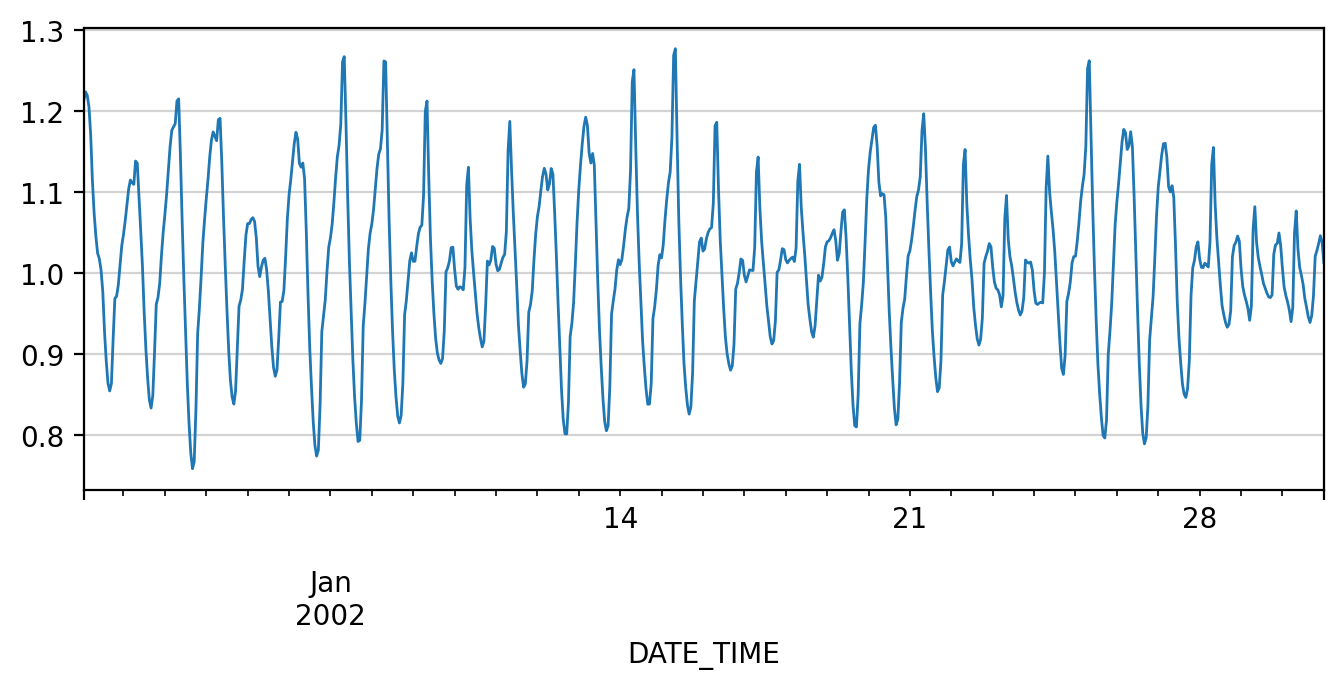

In [12]:
(
    R_d # the residual factors after removing the daily seasonal
    .head(24 * 30) # plot the first 30 days
    .plot()
)

### Analyzing further the $T_d$ Component: Identifying Weekly Patterns

We have extracted three time series (trend, seasonal, residual) from the main time series, after extracting the daily component. Now we will extract the weekly component, which has a duration of `period = 24 * 7` hours.

In [13]:
decompose = seasonal_decompose(T_d,
                                model='multiplicative',
                                period=24 * 7,
                                extrapolate_trend=24 * 7)

T_w, S_w, R_w = decompose.trend, decompose.seasonal, decompose.resid

<Axes: xlabel='DATE_TIME'>

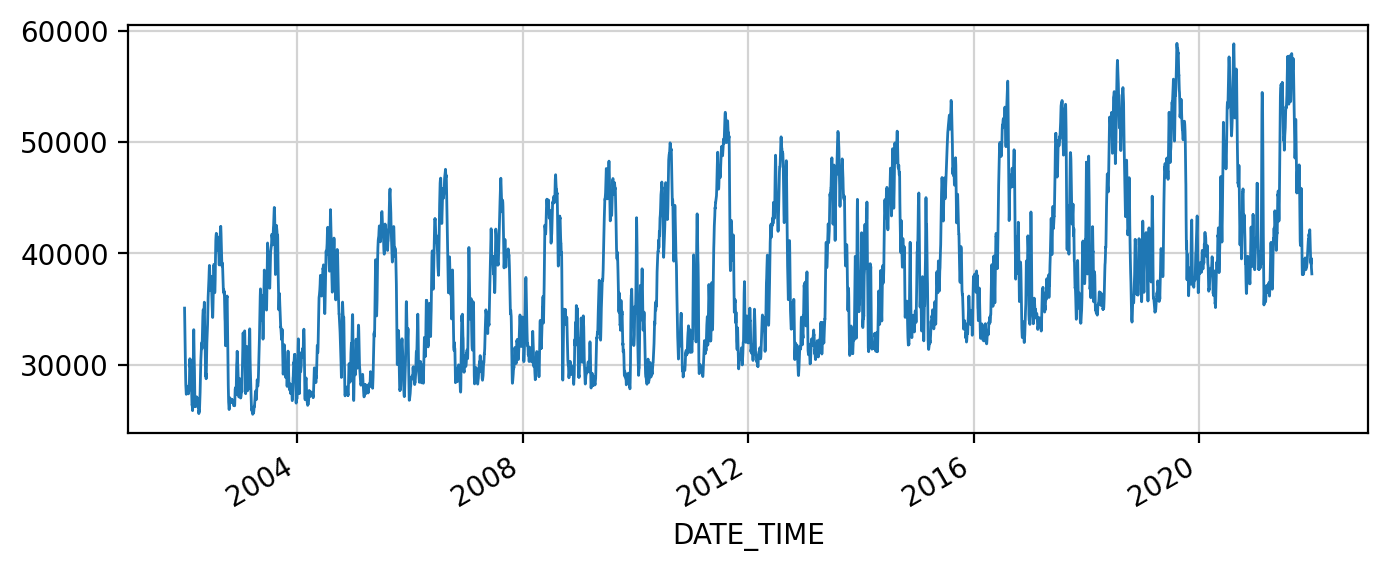

In [14]:
# This is the remaining trend component after removing daily and weekly fluctuations
T_w.plot()

<Axes: xlabel='DATE_TIME'>

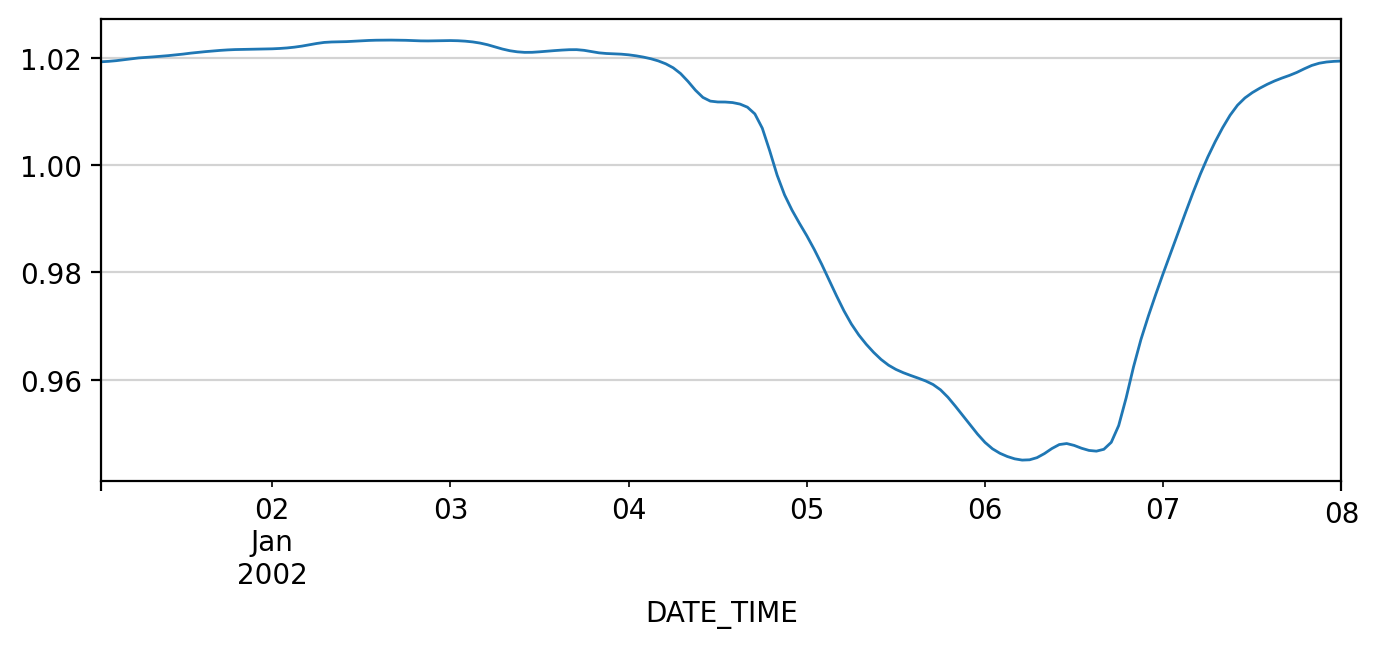

In [15]:
# This shows the weekly seasonality
S_w.head(24*7).plot()

<Axes: xlabel='DATE_TIME'>

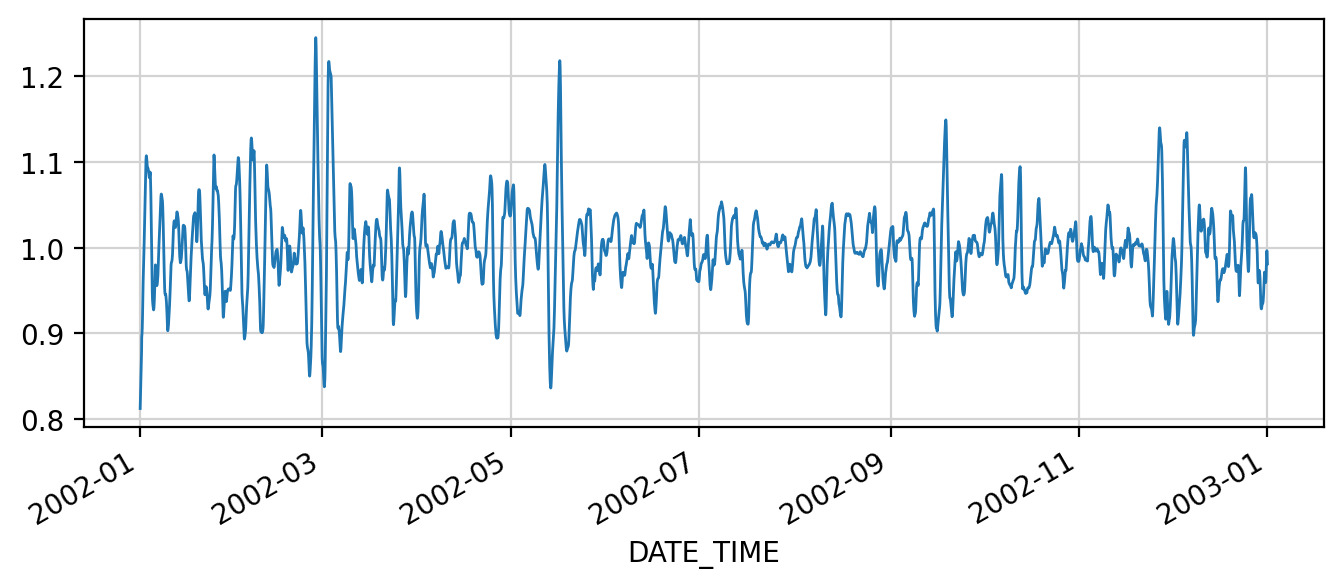

In [16]:
# This shows the residual, after removing the daily and weekly
R_w.head(24*365).plot()

### Analyzing further the $T_w$ Component: Identifying yearly Patterns

In [17]:
decompose = seasonal_decompose(T_w,
                                model='multiplicative',
                                period=24 * 365,
                                extrapolate_trend=24 * 365)

T_y, S_y, R_y = decompose.trend, decompose.seasonal, decompose.resid

<Axes: xlabel='DATE_TIME'>

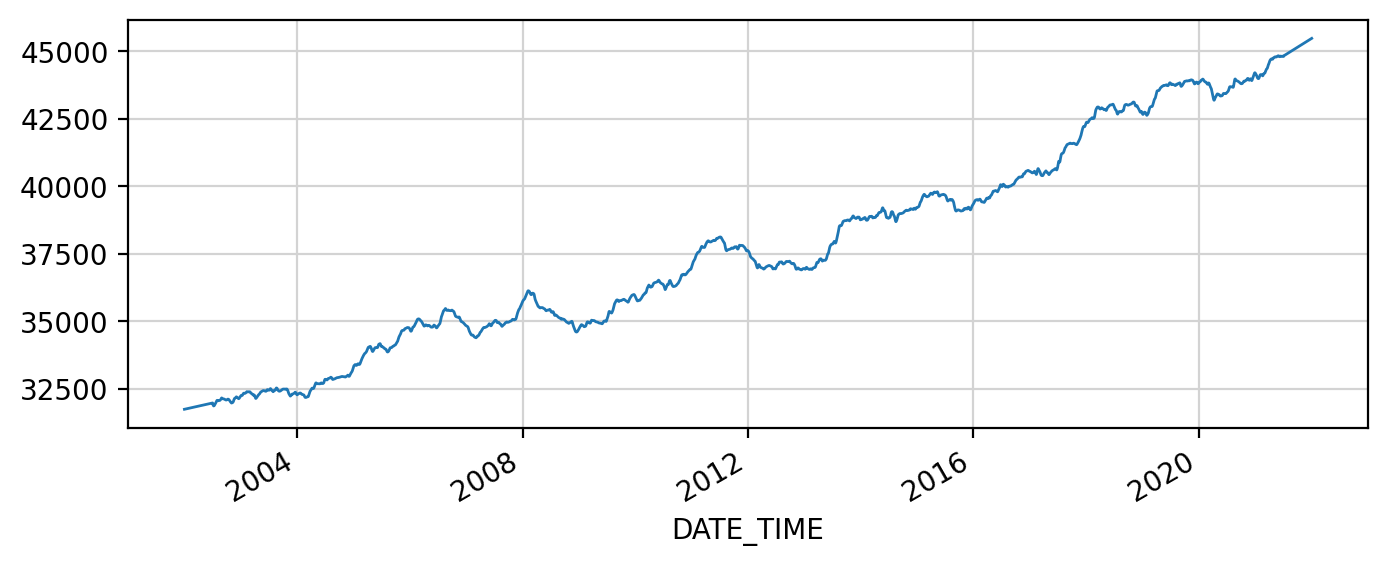

In [18]:
# This shows the overall trend, after removing daily, weekly, and yearly seasonality
T_y.plot()

<Axes: xlabel='DATE_TIME'>

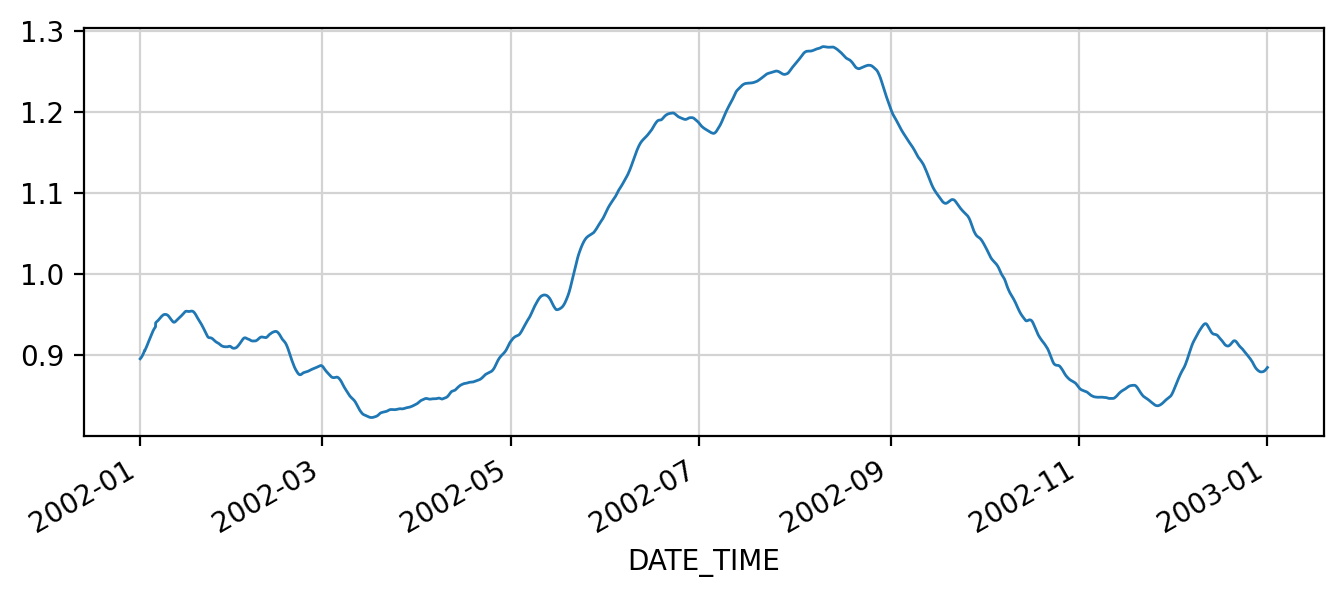

In [19]:
# This shows the yearly seasonality
S_y.head(24*365).plot()

## Summary

<Axes: xlabel='DATE_TIME'>

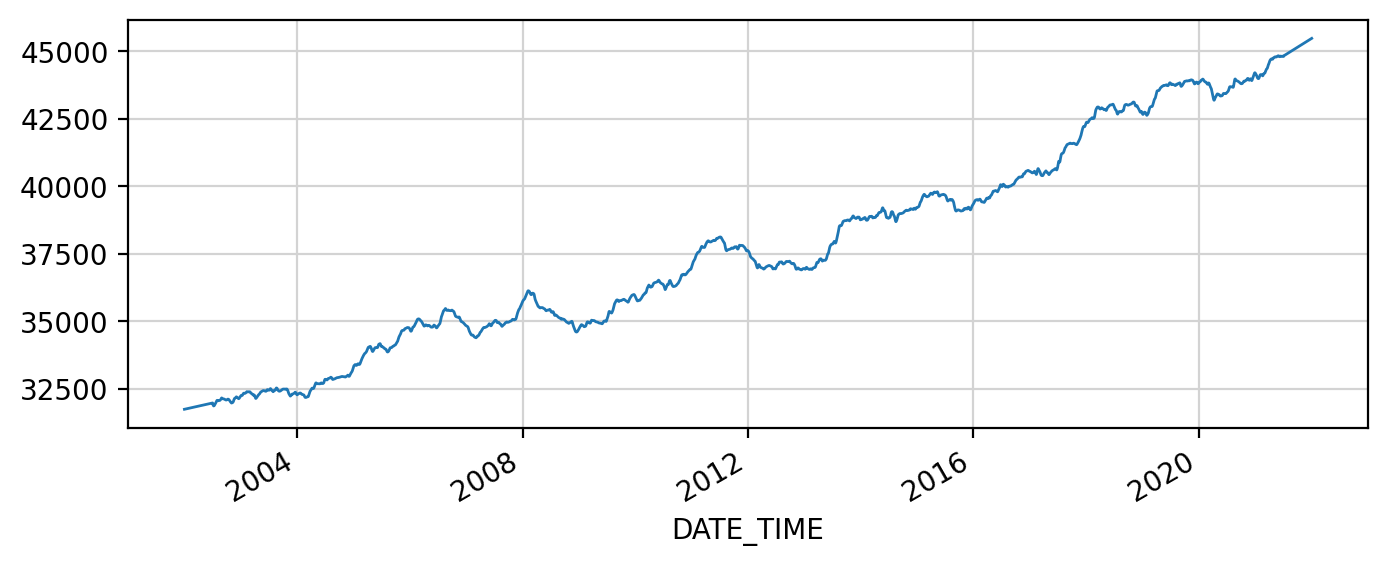

In [20]:
# This shows the overall trend, after removing daily, weekly, and yearly seasonality
T_y.plot()

<Axes: xlabel='DATE_TIME'>

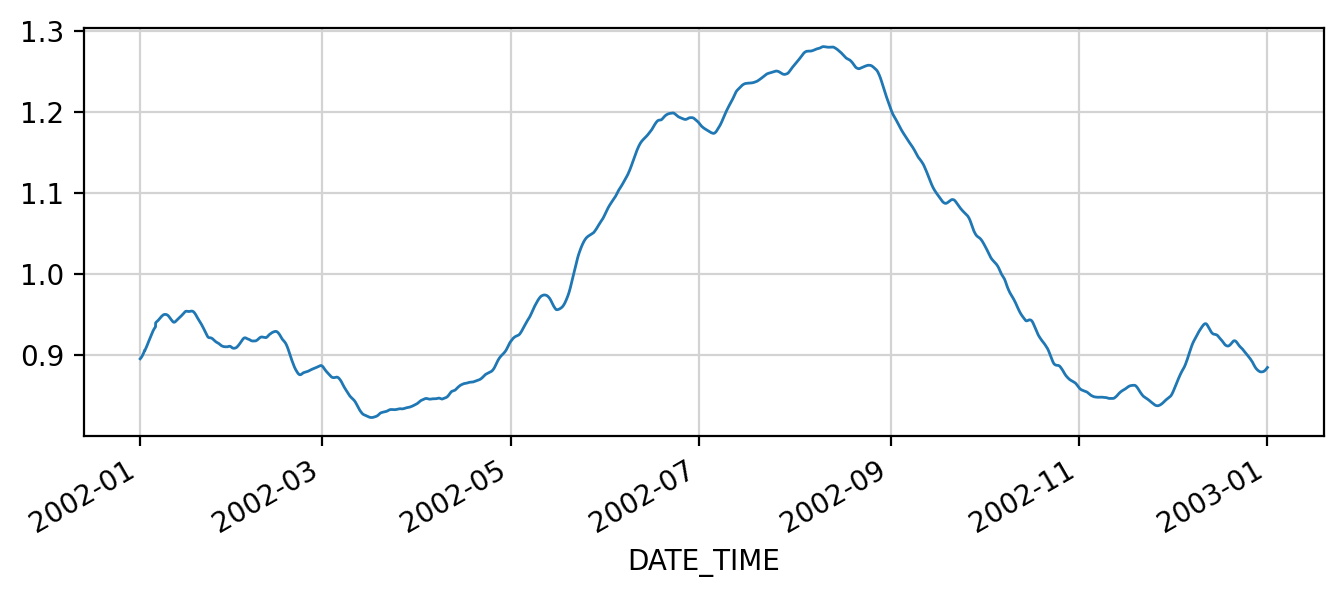

In [21]:
# This shows the yearly seasonality. We show the
# first 365 days * 24 hours as the pattern repeats in subsequent periods
S_y.head(24*365).plot()

<Axes: xlabel='DATE_TIME'>

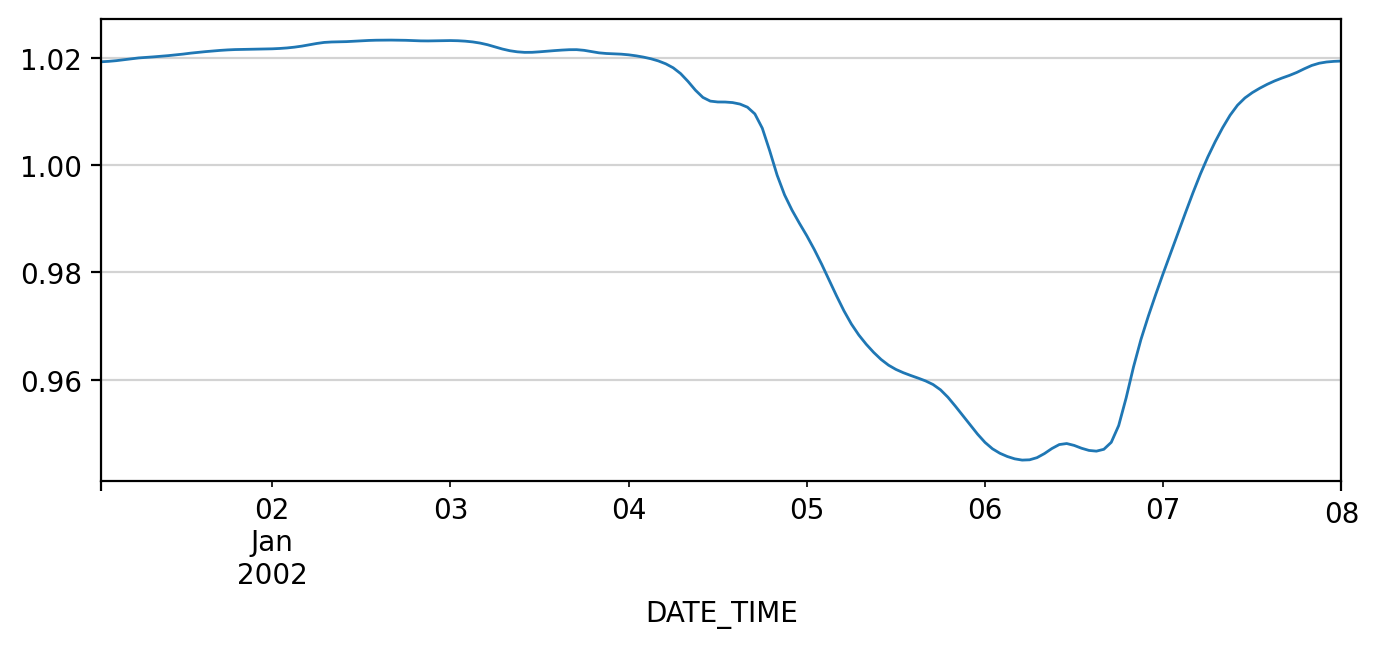

In [22]:
# This shows the weekly seasonality. We show the first
# 7 days multiplied with 24 hours as the pattern repeats in subsequent periods
S_w.head(24*7).plot()

<Axes: xlabel='DATE_TIME'>

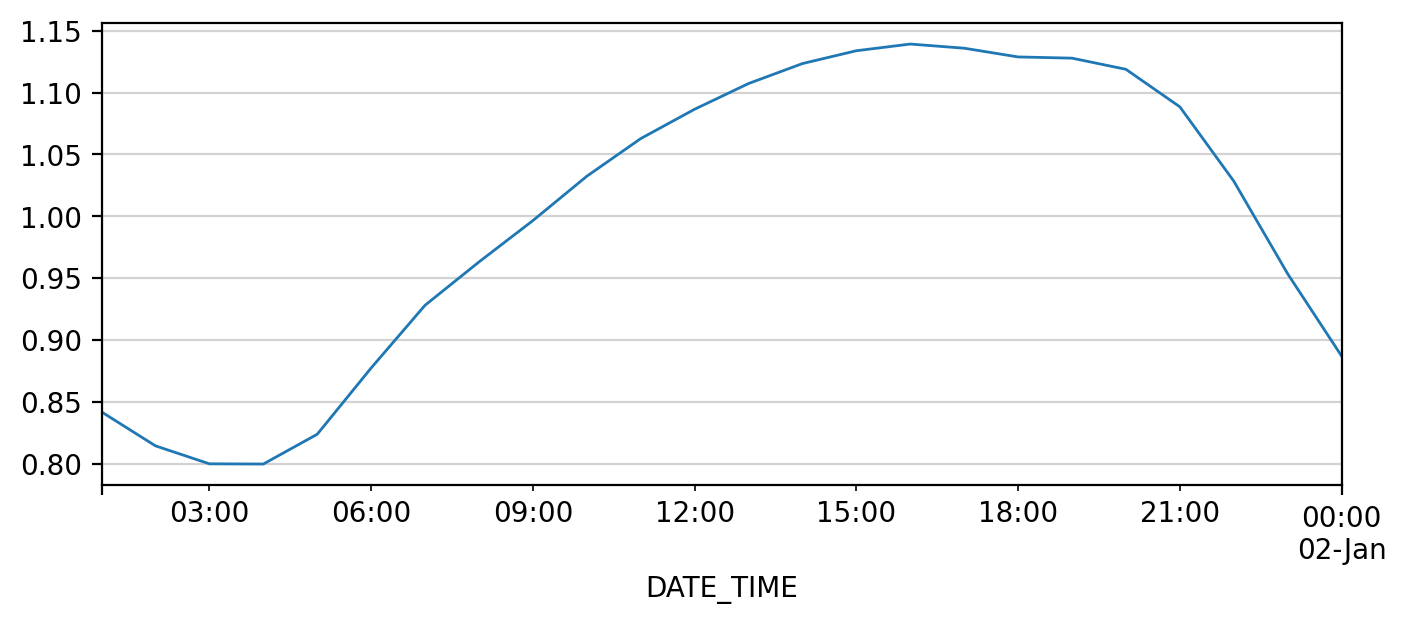

In [23]:
# This shows the daily seasonality. We show the first
# 24 hours, as the pattern repeats in subsequent periods
S_d.head(24).plot()

<Axes: xlabel='DATE_TIME'>

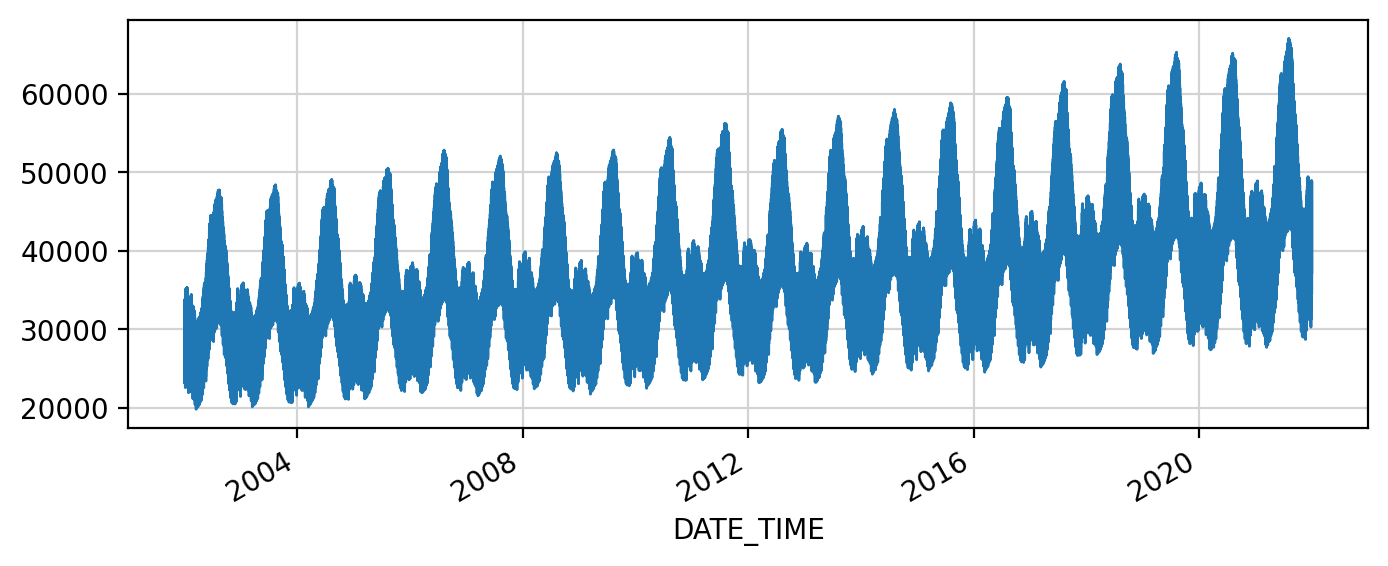

In [24]:
# This is the time series with the overall trend, plus seasonality
(T_y * S_y * S_w * S_d).plot()

<Axes: xlabel='DATE_TIME'>

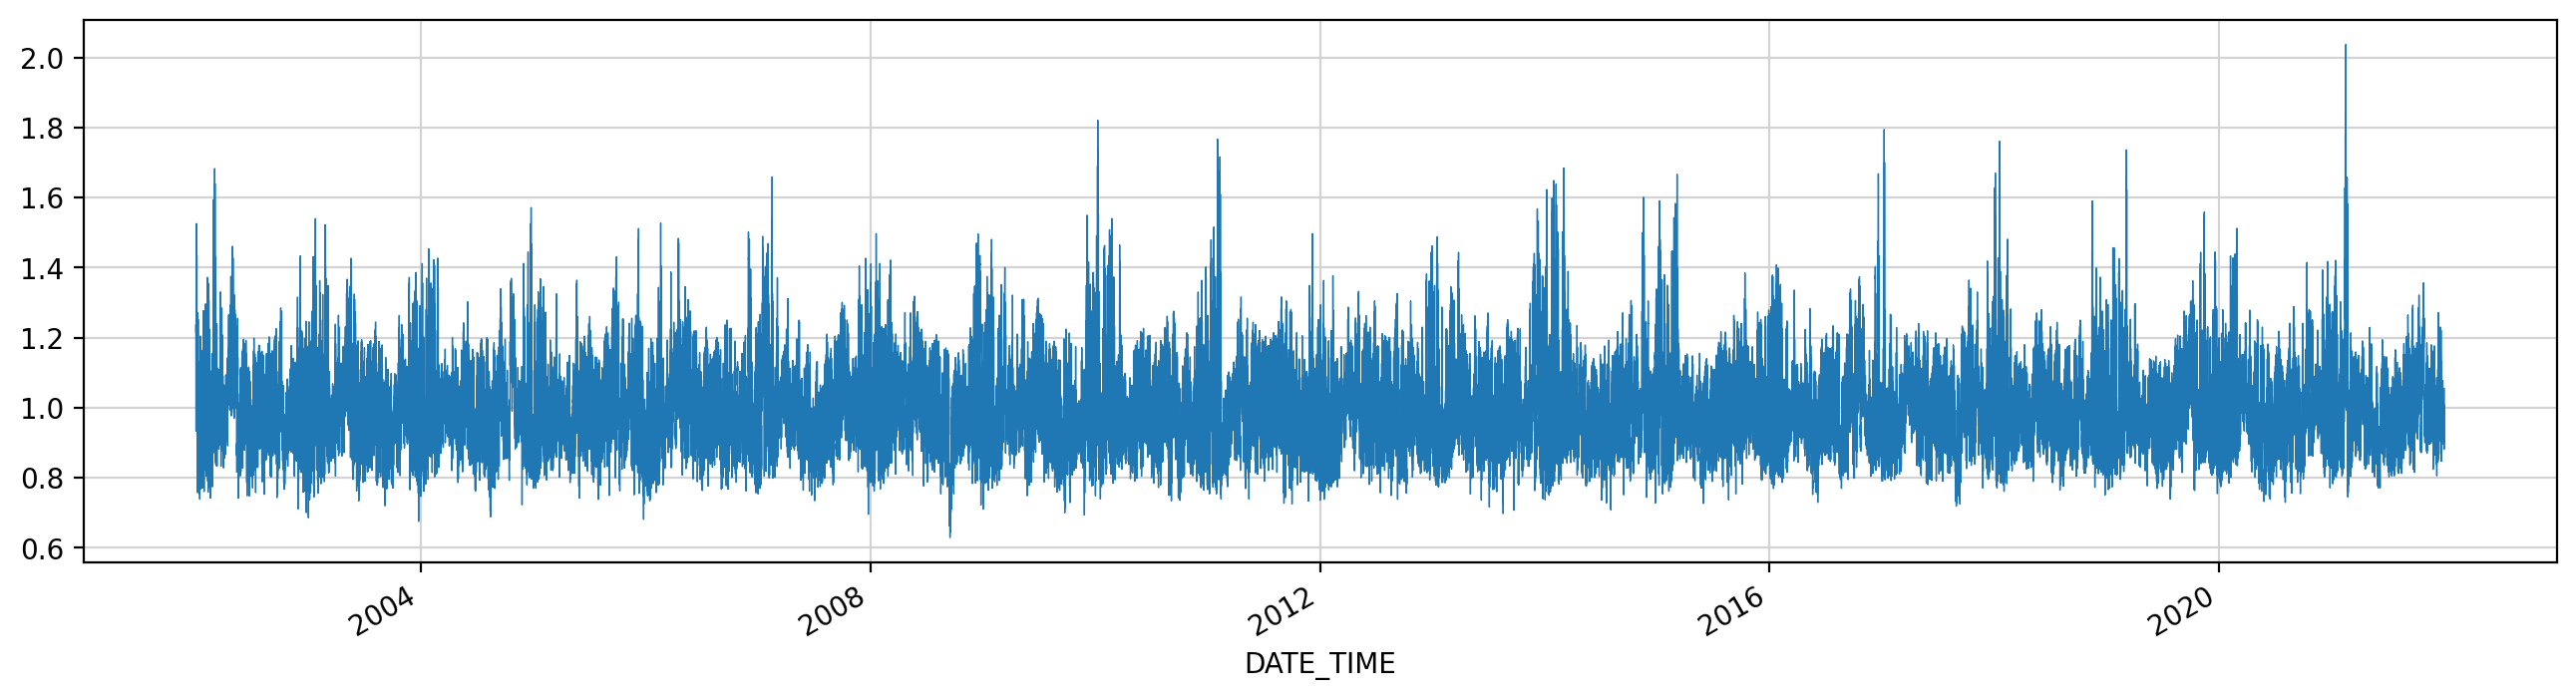

In [25]:
# This is the residual, that is not captured by the trend or seasonality
# When we are modeling, we really talk about forecasting the trend and
# potentially modeling this time series, which has been de-trended
# and de-seasonalized.
( R_y * R_w * R_d ).plot(figsize=(16,4), linewidth=0.5)

In [26]:
# A high autocorrelation means that consumption is
# still clustered in time periods.
(R_y * R_w * R_d).autocorr()

0.9731563230718977

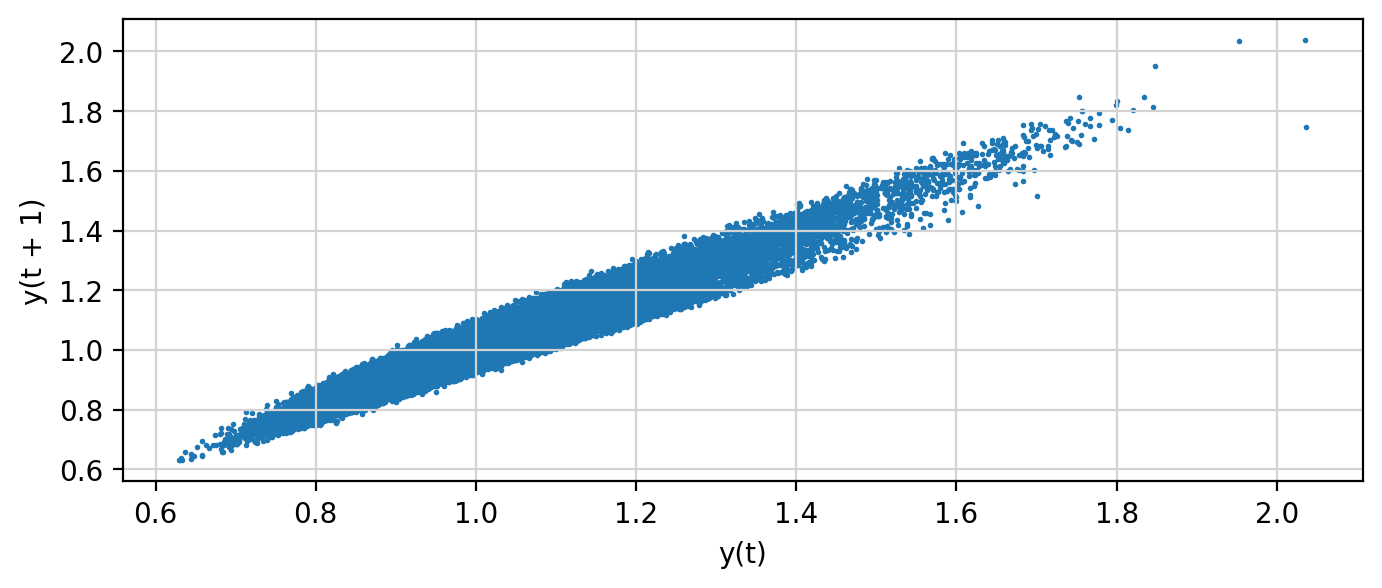

In [27]:
ax = pd.plotting.lag_plot((R_y * R_w * R_d), lag=1, s=1)

<Axes: >

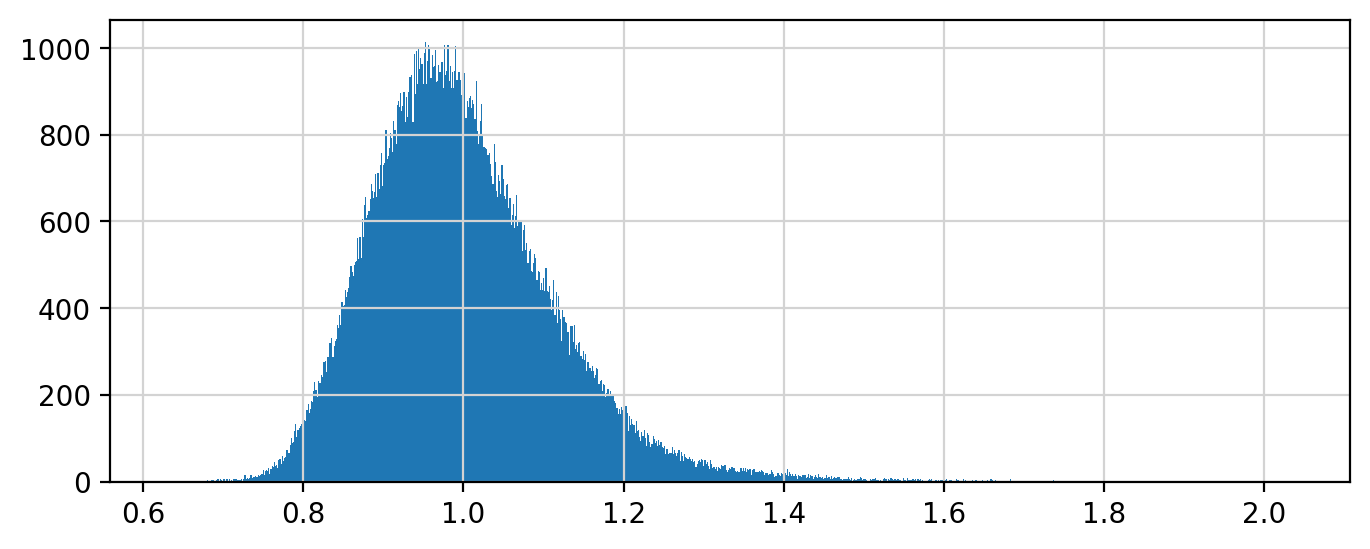

In [28]:
# Here is the histogram of the residuals.
# Since these are multiplicative factors, it is a good idea
# to also take the log and plot them again.
( R_y * R_w * R_d ).hist(bins=1000)

<Axes: >

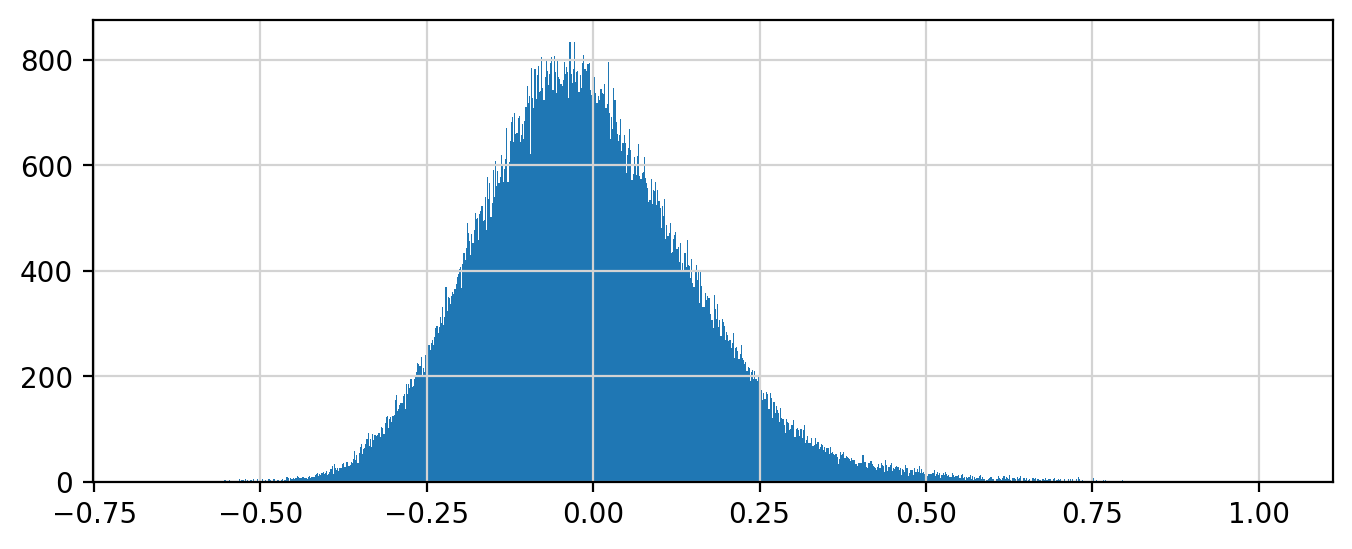

In [35]:
np.log2( R_y * R_w * R_d ).hist(bins=1000)

In [30]:
# Examine the quantiles of the residual distribution
# These are the values with which we need to multiply our
# trend and seasonality projections to estimate maximum capacity
#
# 99% = For 87.6 hours in a year, consumption is above this level
# 99.9% = For 8.76 hours in a year, consumption is above this level
# 99.99% = For 52 mins in a year, consumption is above this level
# 99.999% = For 5.2 mins in a year, consumption is above this level

q=[
    0.00001, 0.0001,0.001,0.01,0.1,0.25,
    0.5,
    0.75,0.9,0.99,0.999,0.9999,0.99999
]
(R_y * R_w * R_d).quantile(q)

0.00001    0.631315
0.00010    0.675196
0.00100    0.734088
0.01000    0.789651
0.10000    0.867143
0.25000    0.920130
0.50000    0.985870
0.75000    1.064033
0.90000    1.147113
0.99000    1.360772
0.99900    1.605892
0.99990    1.758727
0.99999    1.972906
Name: resid, dtype: float64

<Axes: >

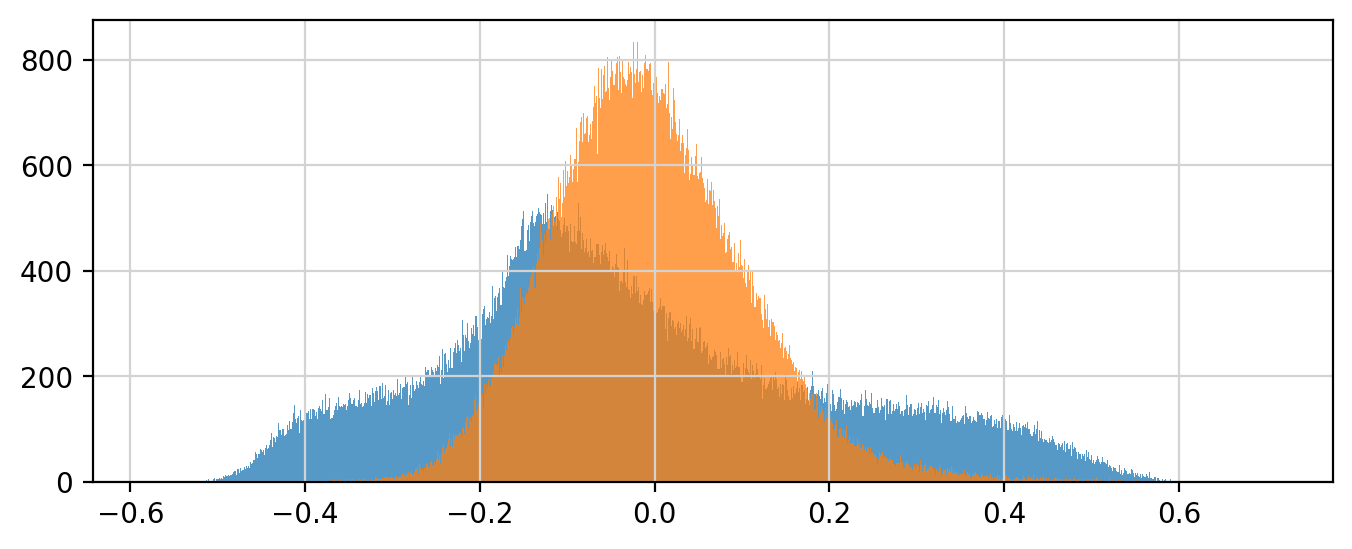

In [31]:
# Plots the histogram of the log of the time series after removing the trend
# The division Y / T_y removes the long term trend from the series and returns
# back the multiplicative factors S_y * S_w * S_d * R_y * R_w * R_d
np.log(Y / T_y).hist(bins=1000, alpha=0.75)

# Now let's remove the seasonal components as well and see the difference
# Plots the histogram of the log of the residuals after removing trend and seasonality
np.log(Y / (T_y * S_y * S_w * S_d)).hist(bins=1000, alpha=0.75)